### Forward modeling part 1
#### project 3: general cases

section 1: HABC with zero $\sigma_0$

1) Physical domain = LiDAR domain + extended zone (width of $\lambda$ --> to reserve the diffraction zone)

2) HABC or transition zone has a width of $\lambda$ --> to ensure the solution is sufficiently accurate.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import scipy.special as sp

from fdfdv5 import FDFD_hybrid_v5

In [20]:
def round_to_int(m):    
    if (m-int(m) >= 0.5): mr = np.ceil(m).astype(int)
    else: mr = np.floor(m).astype(int)    
    return mr

In [52]:
WLEN = 3.0e-3
FREQ = 299792458/WLEN
SCALE = 1.0e-3

GS = 0.2e-3
xHHmin, xHHmax = -6.0e-3, 6.0e-3
yHHmin, yHHmax = -6.0e-3, 6.0e-3

ExtHH = np.array([xHHmin, xHHmax, yHHmin, yHHmax]) / SCALE
xline = np.array([xHHmin, xHHmax, xHHmax, xHHmin, xHHmin]) / SCALE
yline = np.array([yHHmin, yHHmin, yHHmax, yHHmax, yHHmin]) / SCALE

sigma_0 = 0.0

# planewave 's parameters
amp, xsrc, ysrc = 1.0, 0.0e-3, 0.0e-3
theta = 30 # [deg]

# object 's parameters
geometry_1 = -3.0e-3, 3.0e-3, -3.0e-3, 3.0e-3; epsrmat_1 = 1.2
geometry_2 = 0.6e-3, 2.0e-3, 0.6e-3, 2.0e-3; epsrmat_2 = 1.5
geometry_3 = -2.0e-3, -0.6e-3, -2.0e-3, -0.6e-3; epsrmat_3 = 1.0
# geometry_3 = -1.4e-3, -1.4e-3, 0.8e-3; epsrmat_3 = 1.0

# FD 's parameters
typeHHorder, typeOWorder, typeK, typeDamp = '4th', '2nd_bw_2nd', '1', 'non'

### - HABC with zero $\sigma_0$

In [53]:
GS_ref = 0.2e-3 # generate the reference solution
xHHmin_ref, xHHmax_ref = -12.0e-3, 12.0e-3 # generate the reference solution
yHHmin_ref, yHHmax_ref = -12.0e-3, 12.0e-3 # generate the reference solution
nextend = round_to_int((xHHmax_ref - xHHmax)/GS_ref)
nly_ref = 90 # generate the reference solution

thk_ref = nly_ref*GS_ref
nxHH_ref, nyHH_ref = round_to_int((xHHmax_ref-xHHmin_ref)/GS_ref) + 1, round_to_int((yHHmax_ref-yHHmin_ref)/GS_ref) + 1
nx_ref, ny_ref = nxHH_ref + 2*nly_ref, nyHH_ref + 2*nly_ref

x_ref = np.linspace(xHHmin_ref-thk_ref, xHHmax_ref+thk_ref, nx_ref)
y_ref = np.linspace(yHHmin_ref-thk_ref, yHHmax_ref+thk_ref, ny_ref)

sim = FDFD_hybrid_v5(FREQ, GS_ref);   
sim.domain(xHHmin_ref, xHHmax_ref, yHHmin_ref, yHHmax_ref, thk_ref)
sim.create_scatterer('rectangular', geometry_1, epsrmat_1)
sim.create_scatterer('rectangular', geometry_2, epsrmat_2)
sim.create_scatterer('rectangular', geometry_3, epsrmat_3)
# sim.create_scatterer('circle', geometry_3, epsrmat_3)
sim.source(('PLANEWAVE', amp, xsrc, ysrc, theta))

Uinc2D_full, Uscat2D_full, _ = sim.solve_HH('4th', typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
Uscat2D_reference = ((Uscat2D_full[nly_ref:-nly_ref, nly_ref:-nly_ref])[nextend:-nextend, nextend:-nextend])

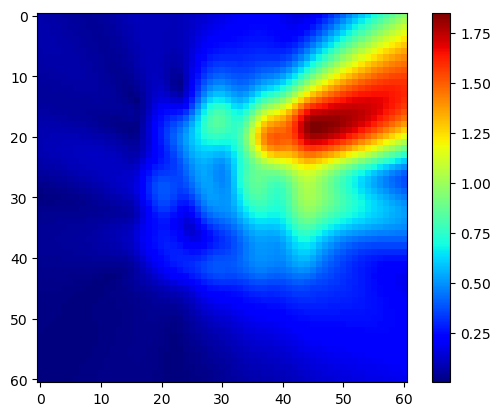

In [54]:
plt.imshow(np.flipud(np.abs(Uscat2D_reference)), cmap='jet'); plt.colorbar(); plt.show()

In [55]:
nlymin, nlymax = 1, 30

nlystep = 1
Nly = np.arange(nlymin, nlymax+1, nlystep)
Score_HABC, Score_ABC = np.zeros_like(Nly, dtype=np.float64), np.zeros_like(Nly, dtype=np.float64) 
nnly = len(Nly)

i = 0
for nly in Nly:
    
    thk = nly*GS

    nxHH, nyHH = round_to_int((xHHmax-xHHmin)/GS) + 1, round_to_int((yHHmax-yHHmin)/GS) + 1
    nx, ny = nxHH + 2*nly, nyHH + 2*nly
    
    x = np.linspace(xHHmin-thk, xHHmax+thk, nx)
    y = np.linspace(yHHmin-thk, yHHmax+thk, ny)

    Ext = np.array([xHHmin-thk, xHHmax+thk, yHHmin-thk, yHHmax+thk]) / SCALE

    sim = FDFD_hybrid_v5(FREQ, GS);   
    sim.domain(xHHmin, xHHmax, yHHmin, yHHmax, thk)
    sim.create_scatterer('rectangular', geometry_1, epsrmat_1)
    sim.create_scatterer('rectangular', geometry_2, epsrmat_2)
    sim.create_scatterer('rectangular', geometry_3, epsrmat_3)
#     sim.create_scatterer('circle', geometry_3, epsrmat_3)
    sim.source(('PLANEWAVE', amp, xsrc, ysrc, theta))
    
    #########################################################################
    Uinc2D_full, Uscat2D_full, Utot2D_full = sim.solve_HH('4th', typeOWorder, 'quadratic', typeK, typeDamp, sigma_0)
    Uinc2D_sim, Uscat2D_sim, Utot2D_sim = Uinc2D_full[nly:-nly, nly:-nly], Uscat2D_full[nly:-nly, nly:-nly], Utot2D_full[nly:-nly, nly:-nly]
    if nly == nlymin: nyHH, nxHH = Uscat2D_sim.shape; Uscat2D_HABC_stack = np.zeros([nyHH, nxHH, nnly], dtype=np.complex128)
    Uscat2D_HABC_stack[:, :, i] = Uscat2D_sim
#     Score[i] = np.linalg.norm(Uscat2D_sim - Uscat2D_reference)**2/(nxHH*nyHH)
    Score_HABC[i] = np.linalg.norm(Uscat2D_sim - Uscat2D_reference) / np.linalg.norm(Uscat2D_reference)
    #########################################################################
    Uinc2D_full, Uscat2D_full, Utot2D_full = sim.solve_HH('4th', typeOWorder, 'zero', typeK, typeDamp, sigma_0)
    Uinc2D_sim, Uscat2D_sim, Utot2D_sim = Uinc2D_full[nly:-nly, nly:-nly], Uscat2D_full[nly:-nly, nly:-nly], Utot2D_full[nly:-nly, nly:-nly]
    if nly == nlymin: nyHH, nxHH = Uscat2D_sim.shape; Uscat2D_ABC_stack = np.zeros([nyHH, nxHH, nnly], dtype=np.complex128)
    Uscat2D_ABC_stack[:, :, i] = Uscat2D_sim
#     Score[i] = np.linalg.norm(Uscat2D_sim - Uscat2D_reference)**2/(nxHH*nyHH)
    Score_ABC[i] = np.linalg.norm(Uscat2D_sim - Uscat2D_reference) / np.linalg.norm(Uscat2D_reference)
    #########################################################################
    i = i + 1

In [56]:
sim.nly

30

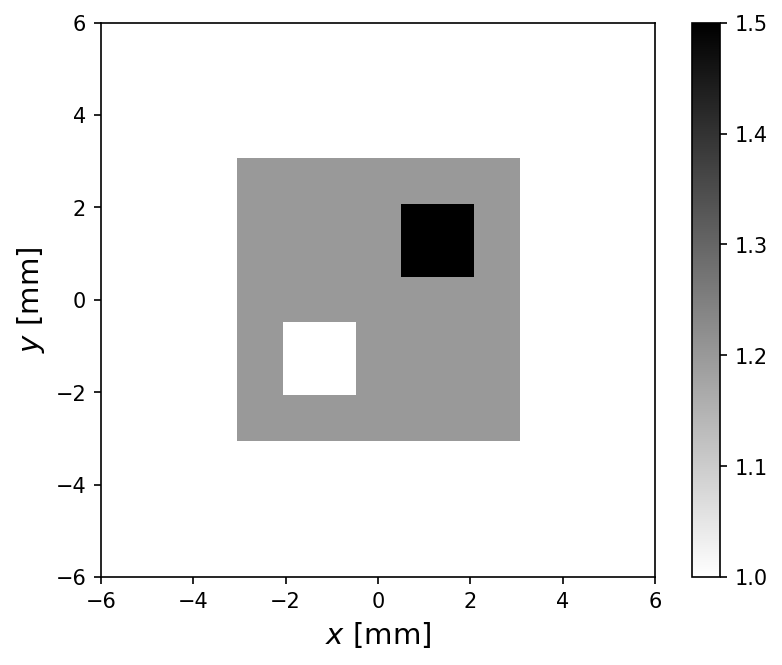

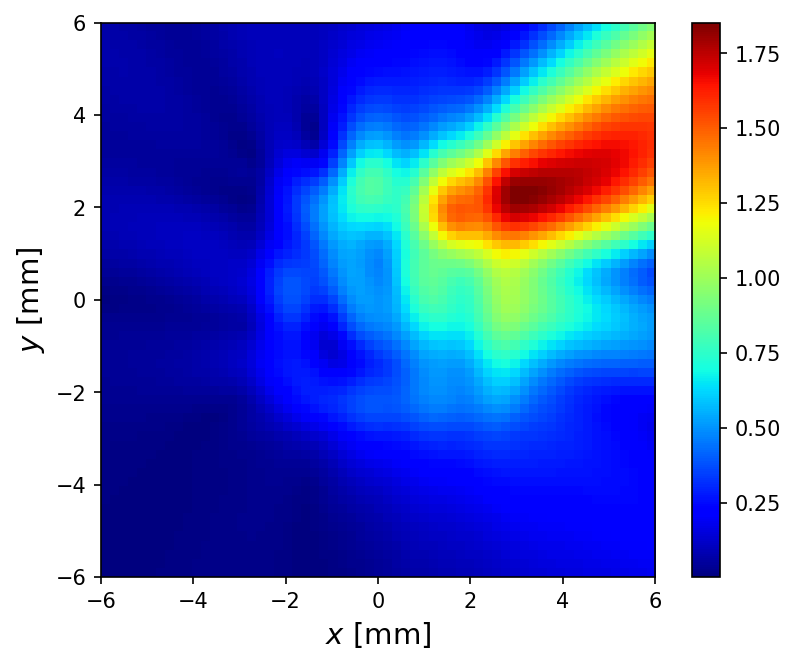

In [63]:
plt.figure(dpi=150); plt.imshow(np.flipud(np.abs(sim.Mat2D[sim.nly:-sim.nly, sim.nly:-sim.nly])), extent=ExtHH, cmap='binary')
plt.xlabel(r'$x$ [mm]', fontsize=14); plt.ylabel(r'$y$ [mm]', fontsize=14); plt.colorbar(); plt.show()

plt.figure(dpi=150); plt.imshow(np.flipud(np.abs(Uscat2D_HABC_stack[:, :, 10-1])), extent=ExtHH, cmap='jet')
plt.xlabel(r'$x$ [mm]', fontsize=14); plt.ylabel(r'$y$ [mm]', fontsize=14); plt.colorbar(); plt.show()

In [58]:
# Score_HABC_GS_1 = np.copy(Score_HABC)
# Score_ABC_GS_1 = np.copy(Score_ABC)
# np.save('Score_HABC_GS_1.npy', Score_HABC_GS_1)
# np.save('Score_ABC_GS_1.npy', Score_ABC_GS_1)

Score_HABC_GS_2 = np.copy(Score_HABC)
Score_ABC_GS_2 = np.copy(Score_ABC)
# np.save('Score_HABC_GS_2.npy', Score_HABC_GS_2)
# np.save('Score_ABC_GS_2.npy', Score_ABC_GS_2)

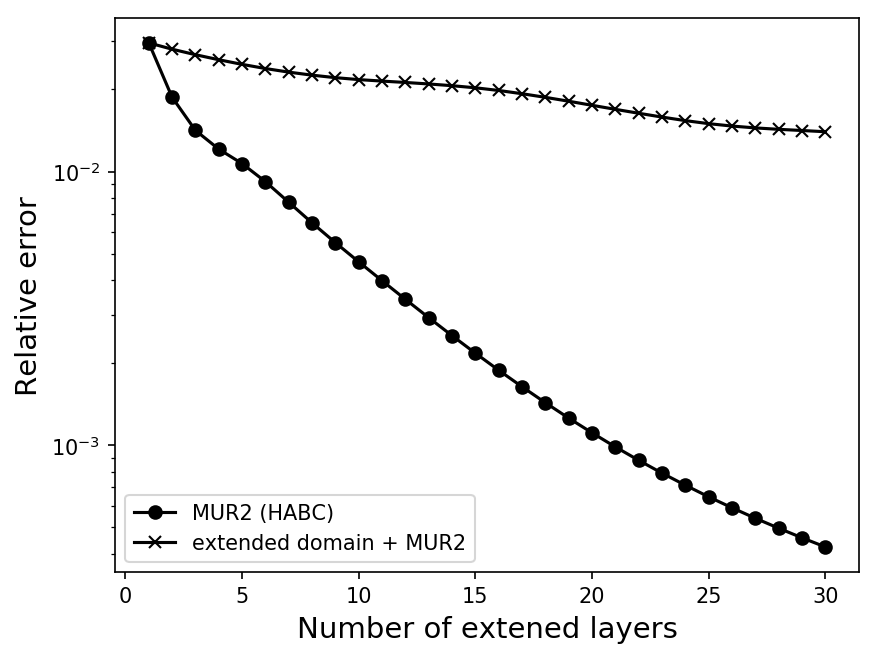

In [61]:
fig, ax = plt.subplots(dpi=150)
# plt.semilogy(Nly, Score_HABC_GS_1, 'o-', label='HABC (GS = 0.1 mm)')
# plt.semilogy(Nly, Score_ABC_GS_1, 'x-', label='ABC (GS = 0.1 mm)')
plt.semilogy(Nly, Score_HABC_GS_2, 'ko-', label='MUR2 (HABC)')
plt.semilogy(Nly, Score_ABC_GS_2, 'kx-', label=r'extended domain + MUR2')
plt.xlabel(r'Number of extened layers', fontsize=14)
plt.ylabel('Relative error', fontsize=14)
# plt.title(f'GS/typeHHorder = {GS/SCALE} mm/{typeHHorder}')
# plt.title('reference = 90-layers_HABC')
plt.legend(); plt.show()

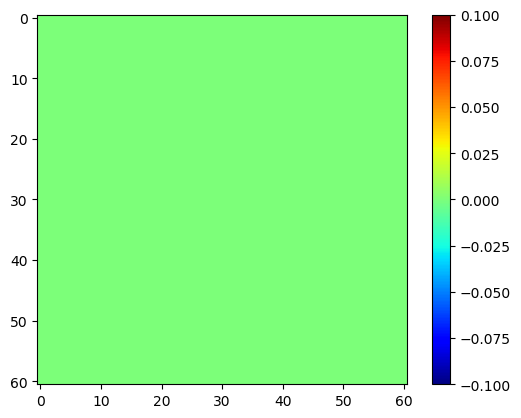

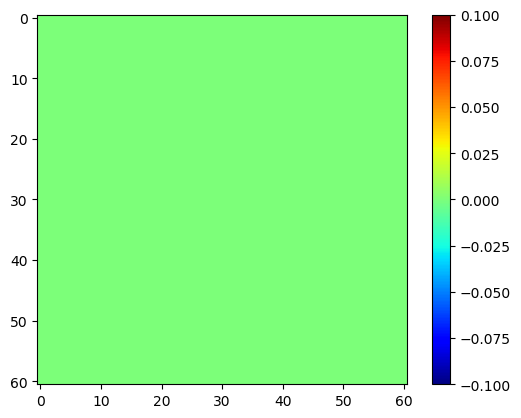

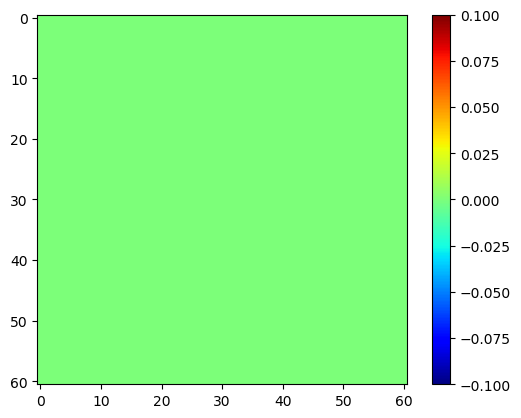

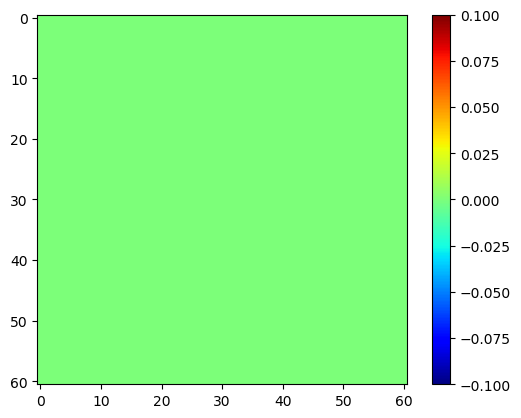

In [18]:
plt.imshow(np.flipud(np.abs(Uscat2D_reference-Uscat2D_ABC_stack[:, :, -1])), cmap='jet'); plt.colorbar(); plt.show()
plt.imshow(np.flipud(np.abs(Uscat2D_reference-Uscat2D_HABC_stack[:, :, -1])), cmap='jet'); plt.colorbar(); plt.show()
plt.imshow(np.flipud(np.abs(Uscat2D_ABC_stack[:, :, -1])), cmap='jet'); plt.colorbar(); plt.show()
plt.imshow(np.flipud(np.abs(Uscat2D_reference)), cmap='jet'); plt.colorbar(); plt.show()

In [ ]:
normdiff = []

for i in range(1, len(Nly)):
    val = np.linalg.norm(Uscat2D_stack[:, :, i] - Uscat2D_stack[:, :, i-1]) / (nxHH*nyHH)
    normdiff = np.append(normdiff, val)
#     normdiff[i] *= 1 / np.linalg.norm(Uscat2D_stack[:, :, i])
# 
plt.figure(dpi=150)
# plt.plot(Nly, normdiff, 'b.-')
plt.semilogy(normdiff, 'b.-')
# xnumber = np.concatenate((np.array([1]), Nly))
# plt.xticks(xnumber)

# plt.plot(Nly, 100*Score/(np.linalg.norm(ref2D)), 'b.', label='compared to ref solution')
plt.ylabel(r'$||u^{sc}_{k}-u^{sc}_{k-1}||$'); plt.show()

In [ ]:
plt.title(f'nx/nxHH/nly = {nx}/{nxHH}/{nly}')
plt.title('Abs[Uscat2D_full]')
plt.imshow(np.flipud(np.abs(Uscat2D_full)), cmap='jet', extent=Ext);
plt.plot(xline, yline, 'w--'); plt.colorbar(); plt.show()

plt.title('Re[Uscat2D_full]')
plt.imshow(np.flipud(np.real(Uscat2D_full)), cmap='jet', extent=Ext);
plt.plot(xline, yline, 'w--'); plt.colorbar(); plt.show()

plt.imshow(np.flipud(np.real(sim.Mat2D)), cmap='jet', extent=Ext)
plt.plot(xline, yline, 'w--'); plt.colorbar(); plt.show()

In [ ]:
# field_HH_large = np.copy(Uscat2D_full)
# field_HH_small = np.copy(Uscat2D_full)w3

diff = field_HH_large - field_HH_small

plt.imshow(np.flipud(np.abs(field_HH_large[50:-50, 50:-50])), cmap='jet')
plt.title('field from large phy and small HABC'); plt.colorbar(); plt.show()
plt.imshow(np.flipud(np.abs(field_HH_small[50:-50, 50:-50])), cmap='jet')
plt.title('field from small phy and large HABC'); plt.colorbar(); plt.show()

plt.imshow(np.flipud(np.abs(diff)), cmap='jet', extent=Ext)
plt.plot(xline, yline, 'w--'); plt.title('abs[diff] (phy + HABC)'); plt.colorbar(); plt.show()

plt.imshow(np.flipud(np.imag(diff[50:-50, 50:-50])), cmap='jet')
plt.title('abs[diff] (phy)'); plt.colorbar(); plt.show()

iymid_full = round_to_int((ny-1)/2)
plt.title(f'profile at horizontal line at y = {y[iymid_full]/SCALE} mm')
plt.plot(np.real(field_HH_large[iymid_full, ::2]), 'bo-', label='large HH')
plt.plot(np.real(field_HH_small[iymid_full, ::2]), 'r.-', label='small HH')
plt.legend(); plt.show()

In [39]:
nly

15

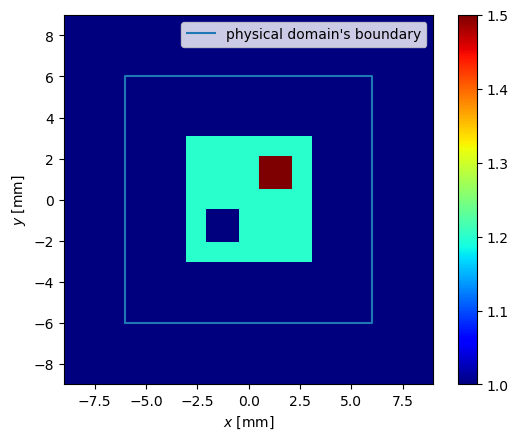

In [40]:
plt.imshow(np.flipud(np.abs(sim.Mat2D)), extent=Ext, cmap='jet')
plt.plot(xline, yline, '-', label='physical domain\'s boundary')
plt.xlabel(r'$x$ [mm]'); plt.ylabel(r'$y$ [mm]'); plt.legend(); plt.colorbar()